In [1]:
import gc
from functools import partial
import pandas as pd
import time
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import similaritymeasures

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loads dataframe of training (w/ classLabels), splits classes, returns two dfs
def load_split_class(run_fold):
    training_data = pd.read_csv("../data/sars/orig/orig_run_" + str(run_fold) + "_train.csv")

    # split classLabel column
    X_train_fold = training_data.iloc[:, :-1]
    y_train_fold = training_data.iloc[:, -1]

    # split pos and neg
    X_train_pos = X_train_fold.loc[y_train_fold == 1]
    X_train_neg = X_train_fold.loc[y_train_fold == 0]
    
    print("Positive samples: %d" % X_train_pos.shape[0])
    print("Negative samples: %d" % X_train_neg.shape[0])
    
    # notebook clean up
    del X_train_fold
    del y_train_fold
    
    return training_data, X_train_pos, X_train_neg

In [3]:
# === VAE GRAPH CONSTRUCTION ===
# this is based on an implementation found in Geron

# layer dimensions
n_inputs = 891
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 50  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001  # set learning rate

# create layer initializer
# TF1 to TF2 migration done by AF, disable eager execution for backwards compatibility
tf.compat.v1.disable_v2_behavior()

# https://devdocs.io/tensorflow~1.15/contrib/layers/variance_scaling_initializer
initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

# define dense layer, uses elu activation function
my_dense_layer = partial(tf.compat.v1.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=initializer)

# placeholder layer for inputs
X = tf.compat.v1.placeholder(tf.float32, [None, n_inputs])

# construct graph layers
hidden1 = my_dense_layer(X, 500)
hidden2 = my_dense_layer(hidden1, 500)
hidden3_mean = my_dense_layer(hidden2, 50, activation=None)
hidden3_gamma = my_dense_layer(hidden2, 50, activation=None)
noise = tf.random.normal(tf.shape(input=hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, 500)
hidden5 = my_dense_layer(hidden4, 500)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

# define cross entropy
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)

# define reconstruction and latent loss
reconstruction_loss = tf.reduce_sum(input_tensor=xentropy)
latent_loss = 0.5 * tf.reduce_sum(input_tensor=tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss  # sum to produce total loss

# use adam optimiser and enforce minimization of loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# create initializer and saver objects
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

# define no. training epochs and no. of spectra to generate
n_epochs = 10000
pos_n_spectra = 11475 # num spectra to sample per run (matches blending)
neg_n_spectra = 11025

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# track training time
start_time = time.time()

for i in range(1, 4):
    print("Training run " + str(i) + " data")
    
    # load data and split pos and neg
    all_data, X_train_pos, X_train_neg = load_split_class(i) # load run file
    
    # clean memory
    del all_data
    gc.collect()
    
    # num spectra to sample per run (matches blending)
    if i == 1:
        xVal = np.array([X_train_pos.columns[j] for j in range(n_inputs)])
    
    # === PRODUCE POSITIVE VAE FOLDS ===
    with tf.compat.v1.Session() as sess:
        init.run()
        
        # train for each epoch
        for epoch in range(n_epochs):
            
            # train
            sess.run(training_op, feed_dict={X: X_train_pos})
                
            print("\r", "Data", "Pos", "Run", i, "Epoch", epoch, end="")
            
            # generate results
            if epoch == n_epochs - 1:
                codings_rnd = np.random.normal(size=[pos_n_spectra, n_hidden3])
                outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})
                
                # Convert to DataFrame
                vae_series = []
                for spectrum in outputs_val:
                    series = pd.Series(data=spectrum, index=xVal)
                    vae_series.append(series)
                    
                pos_vae_spectra = pd.DataFrame(vae_series, dtype="float64")
                pos_vae_spectra['classLabel'] = 1
                                
    print()
    
    # make sure variables are set again
    del X_train_pos
    del vae_series
    del series
    del sess
    gc.collect()
    
    # === PRODUCE NEGATIVE VAE FOLDS ===
    with tf.compat.v1.Session() as sess:
        init.run()
        
        # train for each epoch
        for epoch in range(n_epochs):
            
            # train
            sess.run(training_op, feed_dict={X: X_train_neg})

            print("\r", "Data", "Neg", "Run", i, "Epoch", epoch, end="")

            # generate results
            if epoch == n_epochs - 1:
                codings_rnd = np.random.normal(size=[neg_n_spectra, n_hidden3])
                outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

                # Convert to DataFrame
                vae_series = []
                for spectrum in outputs_val:
                    series = pd.Series(data=spectrum, index=xVal)
                    vae_series.append(series)

                neg_vae_spectra = pd.DataFrame(vae_series, dtype="float64")
                neg_vae_spectra['classLabel'] = 0
    
    # concat blended data
    concat_spectra = pd.concat([pos_vae_spectra, neg_vae_spectra])           
    concat_spectra.to_csv("../data/sars/vae/vae_run_" + str(i) + "_train.csv", index=False)
    
    # blank line for new run
    print()
    
    # make sure variables are set again
    del X_train_neg
    del vae_series
    del series
    del sess
    del concat_spectra
    gc.collect()
    
print("VAE took approx: %s minutes" % round((time.time() - start_time) / 60, 4))

Training run 1 data
Positive samples: 53
Negative samples: 50
 Data Pos Run 1 Epoch 9999
 Data Neg Run 1 Epoch 9999
Training run 2 data
Positive samples: 53
Negative samples: 50
 Data Pos Run 2 Epoch 9999
 Data Neg Run 2 Epoch 9999
Training run 3 data
Positive samples: 53
Negative samples: 50
 Data Pos Run 3 Epoch 9999
 Data Neg Run 3 Epoch 9999
VAE took approx: 4.9079 minutes


In [5]:
dfids = []
spectral_subtractions = []

# calculate coupling distance and spectral subtraction
for i in range(1, 4):
    real_data = pd.read_csv("../data/sars/orig/orig_run_" + str(i) + "_train.csv")
    synth_data = pd.read_csv("../data/sars/vae/vae_run_" + str(i) + "_train.csv")
    
    # Get mean spectra of both - need to reshape for frdist
    mean_real = real_data.iloc[:, :-1].mean().to_numpy().reshape(n_inputs, 1)
    mean_synth = synth_data.iloc[:, :-1].mean().to_numpy().reshape(n_inputs, 1)
    
    dfids.append(similaritymeasures.frechet_dist(mean_real, mean_synth))
    spectral_subtractions.append((mean_real - mean_synth).reshape(1, n_inputs))

distances = pd.DataFrame({'DFIDs': dfids})
distances.head()

,DFIDs
0,0.023865
1,0.029170
2,0.031707


-0.02111900029692515
-0.026108306717209817
-0.031707283329153624


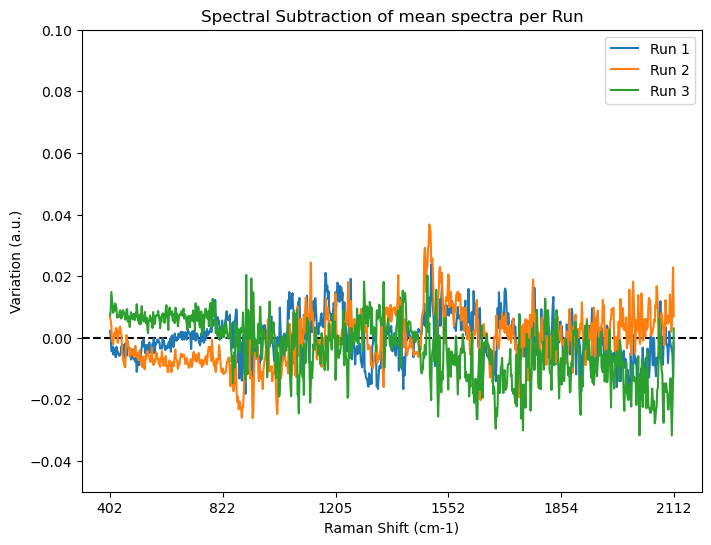

In [6]:
xVal = np.array([real_data.columns[j] for j in range(n_inputs)])
subtractions = pd.DataFrame([], columns=xVal)

for i in range(len(spectral_subtractions)):
    temp = spectral_subtractions[i].reshape(n_inputs)
    subtractions.loc[i] = pd.Series(temp, name=i, index=xVal)


xticks = np.floor(np.linspace(0, n_inputs-1, 6)).astype("int")

# plot
plt.figure(figsize=(8, 6))
plt.xlabel("Raman Shift (cm-1)")
plt.ylabel("Variation (a.u.)")
plt.title("Spectral Subtraction of mean spectra per Run")
plt.xticks(xticks)
plt.ylim([-0.05, 0.1])

plt.axhline(y=0, color='k', linestyle='--')

plt.plot(subtractions.iloc[0, :], label="Run 1")
plt.plot(subtractions.iloc[1, :], label="Run 2")
plt.plot(subtractions.iloc[2, :], label="Run 3")

plt.legend()

print(subtractions.iloc[0].min())
print(subtractions.iloc[1].min())
print(subtractions.iloc[2].min())

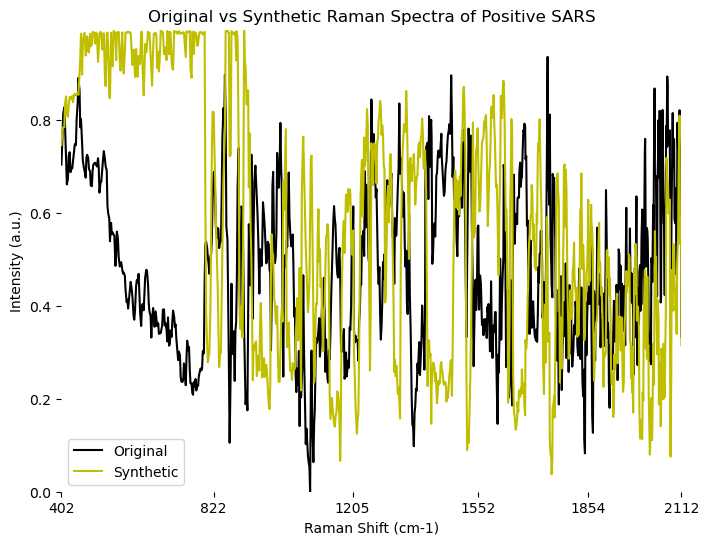

In [7]:
# samples
temp_l = np.concatenate([real_data.iloc[100, :-1].values, synth_data.iloc[0, :-1].values], axis=0).reshape(2, n_inputs)
plot_samples = pd.DataFrame(temp_l, columns=xVal.astype(np.float64))

xticks = plot_samples.columns[[0, 178, 356, 534, 712, 890]].values

# plot
plt.figure(figsize=(8, 6))
plt.xlabel("Raman Shift (cm-1)")
plt.ylabel("Intensity (a.u.)")
plt.title("Original vs Synthetic Raman Spectra of Positive SARS")
plt.xticks(xticks)
plt.margins(0)
plt.box(False)

plt.plot(plot_samples.iloc[0, :], "k", label="Original")
plt.plot(plot_samples.iloc[1, :], "y", label="Synthetic")
     
plt.legend()
#plt.savefig("../figs/vae_orig_v_synth_positive_sample_chlorinated.jpg", bbox_inches='tight')